[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_07_clustering-published.ipynb)

# Clustering

En este notebook implementaremos algunos de los conceptos de _clustering_ vistos en clase.



In [1]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5] # para ver los gráficos más grandes

## Probando K-means y DBSCAN

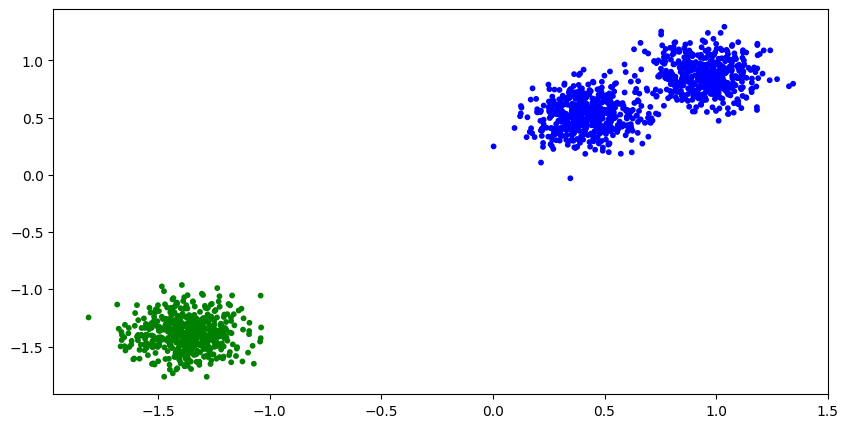

In [2]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

# crear y normalizar dataset
N = 1500
X, y = datasets.make_blobs(n_samples=N, centers=3, cluster_std=1.0,random_state=2211)
X = StandardScaler().fit_transform(X)

# ejecutar k-means con k=2
algorithm = cluster.MiniBatchKMeans(n_clusters=2)
algorithm.fit(X)
y_pred = algorithm.labels_.astype(int)

# graficar
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
plt.show()

**Ejercicio** 
1. Encontrar clusters sobre el mismo dataset utilizando la implementacion de sklearn de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).
2. Experimentar con los hiperparámetros de ambos modelos.

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

def update_view(k):
    algorithm = cluster.MiniBatchKMeans(n_clusters=k)
    algorithm.fit(X)
    y_pred = algorithm.labels_.astype(int)

    # graficar
    colors = np.array([f'C{i}' for i in range(20)])
    colors = np.hstack([colors] * 20)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
    plt.show()
    
# Create sliders for elevation and azimuth angles
k_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='n_clusters: ')

# Link sliders to the update_view function
interact(update_view, k=k_slider)

interactive(children=(IntSlider(value=2, description='n_clusters: ', max=10, min=1), Output()), _dom_classes=(…

<function __main__.update_view(k)>

In [4]:
def update_view(eps, m):
    algorithm = cluster.DBSCAN(eps=eps, min_samples=m)
    algorithm.fit(X)
    y_pred = algorithm.labels_.astype(int)

    # graficar
    colors = np.array([f'C{i}' for i in range(20)])
    colors = np.hstack([colors] * 20)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
    plt.show()
    
# Create sliders for elevation and azimuth angles
eps_slider = widgets.FloatSlider(value=0.04, min=1e-7, max=0.5, step=0.001, description='eps:')
m_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='min_samples:')

# Link sliders to the update_view function
interact(update_view, eps=eps_slider, m=m_slider)

interactive(children=(FloatSlider(value=0.04, description='eps:', max=0.5, min=1e-07, step=0.001), IntSlider(v…

<function __main__.update_view(eps, m)>

# Implementaciones de algoritmos

En esta sección implementarán K-Means, Clustering Aglomerativo, DBScan y GMMs.

## K-Means

Recordemos el algoritmo de KMeans:

```
Hiperparámetros: K

1. Ubicar K centroides al azar.
2. Iterar hasta cumplir con algún criterio de convergencia:

   a. Computar distancias (euclidianas) entre cada punto a cada uno de los centroides.

   b. A cada punto, asignar cluster según cercanía a cada centroide.
   
   c. Mover centroides a la media de cada cluster.

El centroide de un cluster es el vector promedio de las instancias pertenecientes al cluster (vector con promedios de cada atributo).
```

1. Definir la función que inicializa los k centroides al azar: `inicializacion_centroides`.

In [5]:
def inicializacion_centroides(puntos: np.ndarray, k: int, seed = 28) -> np.ndarray:
    """Inicializa los k centroides eligiendo de manera random k de
      los puntos"""
    np.random.seed(seed)
    return puntos[np.random.choice(range(len(puntos)), size=k, replace=False)]

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
inicializacion_centroides(X, 3)


array([[5, 6],
       [1, 2],
       [7, 8]])

2. Completar la función `centroides_cercanos` que calcula, para cada punto, el centroide más cercano que será además donde tendremos a qué cluster pertenece cada uno de los puntos.

In [6]:
def centroides_cercanos(puntos: np.ndarray, centroides: np.ndarray) -> np.ndarray:
    """ Devuelve un array que contiene el indice al centroide más cercano para cada punto."""
    assert puntos.shape[1] == centroides.shape[1], "los elementos de puntos y centroides deben tener la misma dimensión"
    assert centroides.shape[0] > 0, "centroides es no vacio"
    
    p = puntos.shape[1]
    n = puntos.shape[0]
    res = np.zeros(n, dtype=int)
    for j, punto in enumerate(puntos):
        dist_min = np.inf
        cent_min = None
        for i, centroide in enumerate(centroides):
            dist = np.linalg.norm(punto - centroide)
            if dist < dist_min:
                dist_min = dist
                cent_min = i
        res[j] = cent_min
    return res

# Test case 1
puntos = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
centroides = np.array([[1, 2], [3, 4], [5, 6]])
print(centroides_cercanos(puntos, centroides))  # Expected output: [0, 1, 2, 2, 2]

# Test case 2
puntos = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
centroides = np.array([[0, 0], [2, 2]])
print(centroides_cercanos(puntos, centroides))  # Expected output: [0, 0, 1, 1]

[0 1 2 2 2]
[0 0 1 1]


3. Completar la función `mover_centroides` que mueve a los centroides al punto medio de cada cluster y devuelve los nuevos centroides.

In [7]:
puntos = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
cercanos = np.array([0,0, 1, 1])
centroides = np.zeros((2, 2))
for cluster_index in np.unique(cercanos):
    cluster = puntos[cercanos == cluster_index]
    print(f"Cluster {cluster_index}: {cluster}")
    centroides[cluster_index] = np.mean(cluster, axis=0)
print(centroides)  # Expected output: [[0.5, 0.5], [2.5, 2.5]]

Cluster 0: [[0 0]
 [1 1]]
Cluster 1: [[2 2]
 [3 3]]
[[0.5 0.5]
 [2.5 2.5]]


In [8]:
def mover_centroides(puntos: np.ndarray, cercanos: np.ndarray, k: int) -> np.ndarray:
    """ Mueve los centroides a la media de cada cluster."""
    n = puntos.shape[0]
    p = puntos.shape[1]
    nuevos_centroides = np.zeros((k, p))
    for cluster_index in np.unique(cercanos):
        cluster = puntos[cercanos == cluster_index]
        nuevos_centroides[cluster_index] = np.mean(cluster, axis=0)
    return nuevos_centroides

# Test case 1
puntos = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
cercanos = np.array([0, 0, 1, 1, 1, 2])
k = 3
print(mover_centroides(puntos, cercanos, k))  # Expected output: [[2.0, 3.0], [7.0, 8.0], [11.0, 12.0]]

[[ 2.  3.]
 [ 7.  8.]
 [11. 12.]]


4. Probar la implementación de las funciones

In [9]:
def kmeans(puntos: np.ndarray, k: int, max_iters: int = 100) -> np.ndarray:
    """ Algoritmo K-means. """
    centroides = inicializacion_centroides(puntos, k)
    for _ in range(max_iters):
        nuevos_clusters = centroides_cercanos(puntos, centroides)
        centroides = mover_centroides(puntos, nuevos_clusters, k)
        
    return centroides, nuevos_clusters

In [10]:
np.random.seed(42)
puntos = np.random.rand(100, 2)  #100 puntos en dimension 2

def update_view(k):
    centroids, closest = kmeans(puntos, k)

    plt.scatter(puntos[:, 0], puntos[:, 1], c=closest, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], color='red', s=200, alpha=0.5)
    plt.show()
    
# Create sliders for elevation and azimuth angles
k_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='n_clusters: ')

# Link sliders to the update_view function
interact(update_view, k=k_slider)

interactive(children=(IntSlider(value=3, description='n_clusters: ', max=10, min=1), Output()), _dom_classes=(…

<function __main__.update_view(k)>

## Clustering aglomerativo

Ahora compleatremos un algoritmo de clustering jerárquico que utiliza una estrategia _bottom-up_.

### Pseudo-código

```
1. Cada punto es un cluster: C1 = x(1); … ; Cn = x(n) 
2. Calcular una matriz de distancias entre todo par de clusters. 
3. Buscar en la matriz de distancia el par de clusters más similares. 
4. Mergear 2 clusters: A y B según su distancia. 
    a. Borrar las filas de la matriz de distancias correspondientes a los clusters A y B. 
    b. Agregar una nueva fila que contenga la distancia entre A ∪ B y el resto de los clusters. 
5. Repetir los pasos 3 y 4 hasta conseguir la cantidad de clusters deseados (o hasta que haya sólo un cluster). 
```

El objetivo será tener una función:

```python
def aglomerativo(datos, num_clusters=1, criterio_distancia="min")
```

Para ello se propone:

1. Implementar la función `inicializar_distancias(datos)` que toma una matriz de numpy, donde cada fila es una instancia y las columnas son los features y devuelve una matriz de distancias. Las matriz debe ser triangular inferior para calcular las distancias, los valores en y sobre la diagonal deben ser `NaN`.
En este caso usaremos la distancia Euclediana.

In [11]:
def inicializar_distancias(datos: np.ndarray) -> np.ndarray:
    n = datos.shape[0]
    distancias = np.full((n, n), np.nan)
    for i in range(n):
        for j in range(n):
            if i > j:
                distancias[i, j] = np.linalg.norm(datos[i] - datos[j])
    return distancias

In [12]:
# Tests:
X_0 = np.array([[1], [2], [5], [-3]])
y_0_resp = inicializar_distancias(X_0)
y_0_exp = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
np.testing.assert_allclose(y_0_resp, y_0_exp, rtol=1e-5)
print("Pasé test 0")


X_1 = np.array([[1,2], [2,3], [3,5]])
y_1_resp = inicializar_distancias(X_1)
y_1_exp = np.array([[np.nan, np.nan, np.nan], [1.41421356, np.nan, np.nan], [3.60555128, 2.23606798, np.nan]])
np.testing.assert_allclose(y_1_resp, y_1_exp, rtol=1e-5)
print("Pasé test 1")


X_2 = np.array([[5.1, 3.5, 1.4, 0.2], [4.9, 3. , 1.4, 0.2], [4.7, 3.2, 1.3, 0.2], [4.6, 3.1, 1.5, 0.2], [5. , 3.6, 1.4, 0.2]])
y_2_resp = inicializar_distancias(X_2)
y_2_exp = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan],  [0.53851648, np.nan, np.nan, np.nan, np.nan],  [0.50990195, 0.3, np.nan, np.nan, np.nan],  [0.64807407, 0.33166248, 0.24494897, np.nan, np.nan],  [0.14142136, 0.60827625, 0.50990195, 0.64807407, np.nan]])
np.testing.assert_allclose(y_2_resp, y_2_exp, rtol=1e-5)
print("Pasé test 2")

Pasé test 0
Pasé test 1
Pasé test 2


2. Definir la función `encontrar minimo(distancias)` que toma una matriz de distancias como la que se generó en el punto anterior y devuelve la fila y la columna de su menor valor.

In [13]:
from typing import Tuple

def encontrar_minimo(distancias: np.ndarray) -> Tuple[int, int]:
    n = distancias.shape[0]
    i_min = n-1
    j_min = 1
    for i in range(n):
        for j in range(n):
            if i > j and distancias[i, j] < distancias[i_min, j_min]:
                i_min = i
                j_min = j
    return (i_min, j_min)


In [14]:
# Tests:

d_0 = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
pos_0_resp = encontrar_minimo(d_0)
pos_0_exp = (1,0)
np.testing.assert_allclose(pos_0_resp, pos_0_exp, rtol=1e-5)
print("Pasé test 0")


d_1 = np.array([[np.nan, np.nan, np.nan], [1.41421356, np.nan, np.nan], [3.60555128, 2.23606798, np.nan]])
pos_1_resp = encontrar_minimo(d_1)
pos_1_exp = (1,0)
np.testing.assert_allclose(pos_1_resp, pos_1_exp, rtol=1e-5)
print("Pasé test 1")


d_2 = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan],  [0.53851648, np.nan, np.nan, np.nan, np.nan],  [0.50990195, 0.3, np.nan, np.nan, np.nan],  [0.64807407, 0.33166248, 0.24494897, np.nan, np.nan],  [0.14142136, 0.60827625, 0.50990195, 0.64807407, np.nan]])
pos_2_resp = encontrar_minimo(d_2)
pos_2_exp = (4,0)
np.testing.assert_allclose(pos_2_resp, pos_2_exp, rtol=1e-5)
print("Pasé test 2")

Pasé test 0
Pasé test 1
Pasé test 2


3. Definir la función `actualizar_distancias(distancias, i, j, criterio="min")` que toma una matriz de distancias y recalcula la distancia de un nuevo cluster que sea la unión del que tiene índice $i$ con el de índice $j$, que saque las columnas $i$ y $j$ y agregue una nueva columna/fila al final con las distancias de este nuevo cluster armado con los demás. Debe al menos tener el criterio de distancias entre clusters "mínimo" u "máximo", opcionalmente se puede completar con "vinculación promedio".

In [15]:
def actualizar_distancias(d: np.ndarray, i_0: int, j_0: int, criterio: str = "min") -> np.ndarray:
    n = d.shape[0]
    for i in range(n):
        if i != i_0 and i != j_0:
            a, b = sorted([i_0, i])
            k, l = sorted([j_0, i])
            if criterio == "min":
                d[b, a] = min(d[b, a], d[l, k])
            elif criterio == "max":
                d[b, a] = max(d[b, a], d[l, k])
            else:
                raise ValueError("Criterio no válido")
    
    # Remove rows and columns corresponding to j_0
    d = np.delete(d, j_0, axis=0)
    d = np.delete(d, j_0, axis=1)
    return d

In [16]:
# Tests:

d_0 = np.array([[np.nan, np.nan, np.nan, np.nan], [1., np.nan, np.nan, np.nan], [ 4., 3., np.nan, np.nan], [4.,  5., 8., np.nan]])
pos_0_resp = actualizar_distancias(d_1,1,0)
pos_0_exp = np.array([[np.nan, np.nan], [2.23606798, np.nan]])
np.testing.assert_allclose(pos_0_resp, pos_0_exp, rtol=1e-5)
print("Pasé test 0")

Pasé test 0


In [17]:
def aglomerativo(datos, num_clusters=1, criterio_distancia="min"):
    distancias = inicializar_distancias(datos)

    uniones = []
    clusters = [[idx] for idx,_ in enumerate(datos)]
    nombres_de_clusters = [idx for idx,_ in enumerate(datos)]
    prox_cluster = len(nombres_de_clusters) 

    while distancias.shape[0] > num_clusters:
        # Buscar el par de clusters más similares
        i, j = encontrar_minimo(distancias)
        d = distancias[i][j]
        
        # Fusionar los clusters A y B
        nuevo_cluster = clusters[i]
        nuevo_cluster.extend(clusters[j])
        clusters.append(nuevo_cluster)

        # agrego la unión que realizo
        uniones.append([nombres_de_clusters[i], nombres_de_clusters[j], d, len(nuevo_cluster)])

        # agrego la composición del nuevo cluster
        nombres_de_clusters.append(prox_cluster)
        prox_cluster+=1

        # Actualizar la matriz de distancias
        distancias = actualizar_distancias(distancias, i, j, criterio=criterio_distancia)

        # Sacar la info de los clusters sin fusionar
        clusters = [c for idx,c in enumerate(clusters) if idx not in [i,j]]
        nombres_de_clusters = [n for idx,n in enumerate(nombres_de_clusters) if idx not in [i,j]]


    return clusters, np.array(uniones)

4. Revisar el código de `aglomerativo` y correrlo para el ejemplo

    ```python
        X = np.array([[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]])

        cl, u = aglomerativo(X, criterio="max")

        fig = plt.figure(figsize=(10, 6),facecolor='white')
        dn = dendrogram(u)
    ```

    Verificar que obtienen un resultado equivalente al mostrado como ejemplo de [esta página](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

In [18]:
X = np.array([[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]])

cl, u = aglomerativo(X, criterio_distancia="max")
cl, u
#fig = plt.figure(figsize=(10, 6),facecolor='white')
#dn = dendrogram(u)
#plt.show()

([[4, 0], [6, 5, 2, 1, 7, 3, 6, 5, 2, 1, 7, 3]],
 array([[ 6.,  5.,  0.,  2.],
        [ 8.,  2.,  0.,  3.],
        [ 4.,  0.,  1.,  2.],
        [ 9.,  1.,  1.,  4.],
        [11.,  7.,  2.,  5.],
        [12.,  3.,  4.,  6.],
        [13., 13., nan, 12.]]))

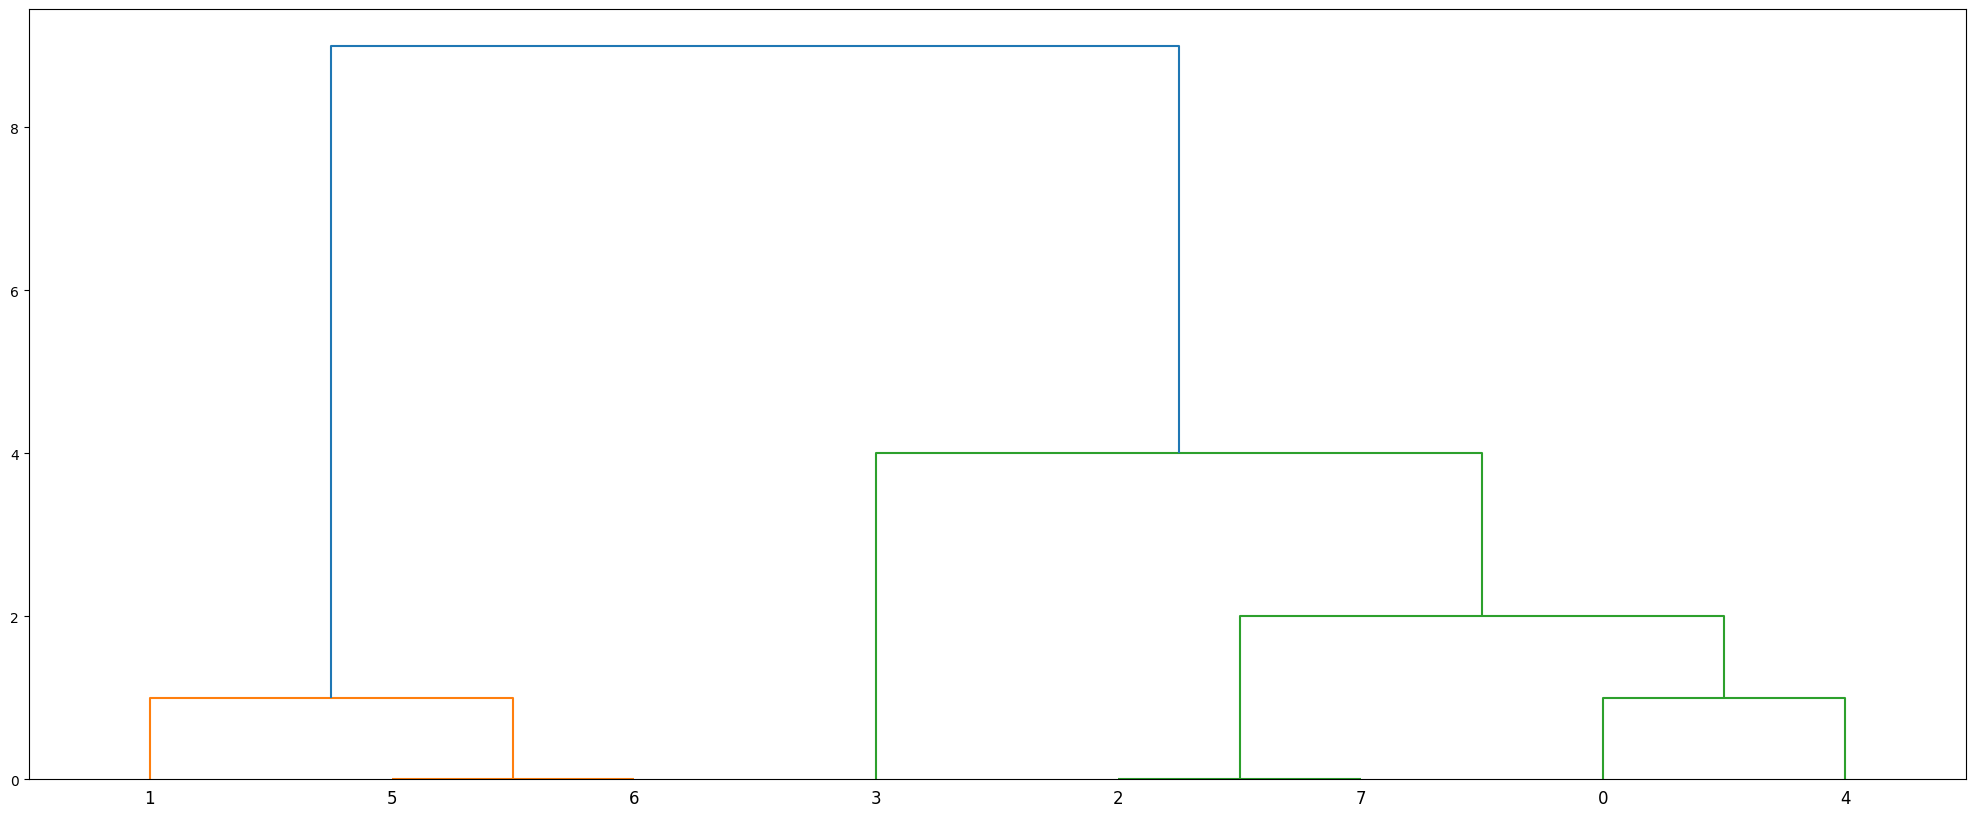

In [19]:
Z = linkage(X, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

5. Crear un dendograma con el dataset de Iris y verificar si la clusterización generada es o no consistente con lo expresado en los targets

    ```python
        # Cargamos el dataset que usaremos hoy
        from sklearn.datasets import load_iris
        iris_dataset = load_iris()

        X = pd.DataFrame(iris_dataset.data)
        y = pd.Series(iris_dataset.target)
    ```

    Explorar las siguientes condiciones:

    1. Criterio de distancias

    1. ¿Se obtiene una mejor, peor o similar clusterización al normalizar los atributos?
 

In [20]:
# Cargamos el dataset que usaremos hoy
from sklearn.datasets import load_iris
import pandas as pd
iris_dataset = load_iris()

X = pd.DataFrame(iris_dataset.data)
y = pd.Series(iris_dataset.target)

def update_view(criterio):
    u = linkage(X, criterio)
    fig = plt.figure(figsize=(15, 8))
    dn = dendrogram(u, labels=y.values, leaf_rotation=0)
    plt.show()
    
# Create sliders for elevation and azimuth angles
criterio = widgets.Dropdown(value='single', description='Criterio: ', options=['single', 'complete', 'average'])

# Link sliders to the update_view function
interact(update_view, criterio=criterio)


interactive(children=(Dropdown(description='Criterio: ', options=('single', 'complete', 'average'), value='sin…

<function __main__.update_view(criterio)>

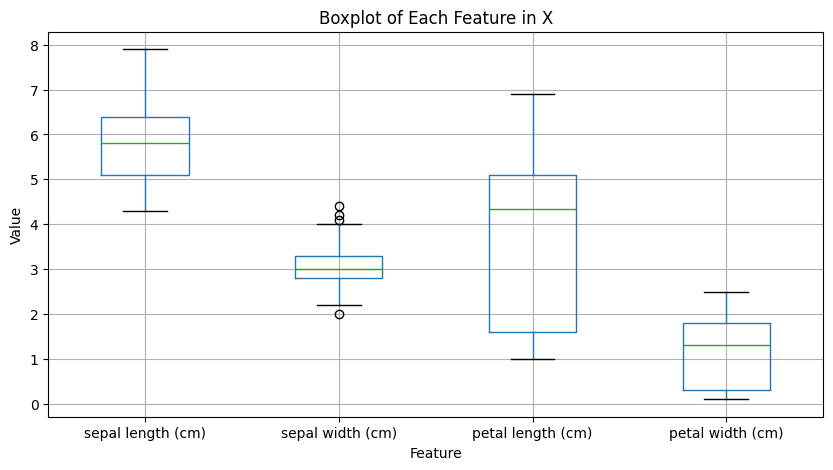

In [21]:
X.columns = iris_dataset.feature_names  # Set feature names as column labels
X.boxplot()
plt.title("Boxplot of Each Feature in X")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.show()

## DBScan

**Algoritmo** Hiper*HiperParámetros*: ***m (min_samples)***, ***ε (epsilon)***. 

1. *Etiquetar a todo punto:*
   1. como **Core** si tiene al menos ***m*** vecinos a menos de ***ε*** distancia.
   2. **Non-Core** si no.
2. Conectamos a **cada core point con sus vecinos** formando un grafo.
3. A partir de cada punto **Core** escanear a qué puntos puede llegar a través de saltos en este grafo. 
4. Clasificamos a los **Non-Core** como:
   1. **Border**: si quedó conectado en el grafo (es decir, si tenía al menos un core en su vecindario y no es core).
   2. **Noise**: al resto.
5. Cada componente conexa se corresponde a un cluster. 
6. No asignamos ningún cluster a los puntos **Noise**.

1. Se tiene una lista con los vecinos más cercanos a cada punto dada por ´encontrar_vecinos´. Implementar la función encontrar_puntos_core que devuelve un array con el tipo de punto para cada uno.

In [28]:
from sklearn.neighbors import NearestNeighbors
from typing import List

def encontrar_vecinos(X: np.ndarray, epsilon: float) -> List[List[int]]:
    # Implementación del Paso 1: Encontrar vecinos a menos de epsilon distancia
    neigh = NearestNeighbors(radius=epsilon)
    neigh.fit(X)
    return neigh.radius_neighbors(X, epsilon, return_distance=False)

def etiquetar_puntos_core(vecinos: List[List[int]], min_samples: int) -> np.ndarray:
    # Implementación del Paso 1.1 y 1.2: Etiquetar puntos como Core o Non-Core
    n = len(vecinos)
    puntos = np.array(['non-core'] * n)
    for i, vec in enumerate(vecinos):
        if len(vec) >= min_samples:
            puntos[i] = 'core'
    return puntos


In [29]:
# Test cases for encontrar_vecinos
X_test = np.array([[0, 0], [1, 1], [2, 2], [8, 8]])
epsilon_test = 2.0
vecinos_test = encontrar_vecinos(X_test, epsilon_test)
print("Vecinos encontrados:", vecinos_test)
# Expected output: [[0, 1], [0, 1, 2], [1, 2], [3]]

# Test cases for etiquetar_puntos_core
min_samples_test = 2
puntos_test = etiquetar_puntos_core(vecinos_test, min_samples_test)
print("Puntos etiquetados:", puntos_test)
# Expected output: ['core', 'core', 'core', 'non-core']

Vecinos encontrados: [array([0, 1]) array([0, 1, 2]) array([1, 2]) array([3])]
Puntos etiquetados: ['core' 'core' 'core' 'non-core']


2. Implementación del paso 3: Expandir cluster a partir de un punto Core.

In [23]:
def expandir_cluster(idx: int, vecinos: List[List[int]], puntos: np.ndarray, 
                     cluster_labels: np.ndarray, cluster_id: int) -> np.ndarray:
    '''
    idx: índice del punto core a expandir
    vecinos: lista de listas de vecinos de cada punto
    puntos: etiquetados como 'core' o 'non-core' de cada punto
    cluster_labels: etiquetas de los clusters de cada punto
    cluster_id: id del cluster a expandir
    '''
    # Implementación del Paso 3: Expandir cluster a partir de un punto Core
    vecinos_idx = vecinos[idx]
    for vecino in vecinos_idx:
        if cluster_labels[vecino] == -1:
            cluster_labels[vecino] = cluster_id
    return cluster_labels

def formar_clusters(puntos: np.ndarray, vecinos: List[List[int]]) -> np.ndarray:
    # Implementación del Paso 2 y 3: Conectar core points y formar clusters
    n_points = len(puntos)
    cluster_labels = np.full(n_points, -1, dtype=int)
    cluster_id = 0
    for idx, label in enumerate(puntos):
        if label == 'core' and cluster_labels[idx] == -1:
            cluster_labels[idx] = cluster_id
            cluster_labels = expandir_cluster(idx, vecinos, puntos, cluster_labels, cluster_id)
            cluster_id += 1
    return cluster_labels

3. A cada punto Non-Core clasificarlo como Border o Noise

In [24]:
def clasificar_non_core(puntos, vecinos):
    # Implementación del Paso 4: Clasificar puntos Non-Core como Border o Noise
    for idx in range(len(puntos)):
        if puntos[idx] == 'non-core':
            puntos[idx] = 'noise'
            # Verificar si tiene algún vecino core
            for vecino in vecinos[idx]:
                if puntos[vecino] == 'core':
                    puntos[idx] = 'border'
                    break
    return puntos

In [25]:
# Test cases for clasificar_non_core
def test_clasificar_non_core_simple():
    puntos = ['core', 'non-core', 'non-core', 'core']
    vecinos = [
        [1],      # 0 es core, vecino 1
        [0, 2],   # 1 es non-core, vecinos 0(core) y 2(non-core)
        [1, 3],   # 2 es non-core, vecinos 1(non-core) y 3(core)
        [2]       # 3 es core, vecino 2
    ]

    resultado = clasificar_non_core(puntos.copy(), vecinos)
    expected = ['core', 'border', 'border', 'core']
    assert resultado == expected, f"Esperaba {expected}, obtuvo {resultado}"
    print("✅ test_clasificar_non_core_simple passed.")

def test_clasificar_non_core_noise():
    puntos = ['core', 'non-core', 'non-core', 'core']
    vecinos = [
        [],       # 0 es core, sin vecinos
        [2],      # 1 es non-core, vecino 2(non-core)
        [1],      # 2 es non-core, vecino 1(non-core)
        []        # 3 es core, sin vecinos
    ]

    resultado = clasificar_non_core(puntos.copy(), vecinos)
    expected = ['core', 'noise', 'noise', 'core']
    assert resultado == expected, f"Esperaba {expected}, obtuvo {resultado}"
    print("✅ test_clasificar_non_core_noise passed.")

# Ejecutar tests
test_clasificar_non_core_simple()
test_clasificar_non_core_noise()

✅ test_clasificar_non_core_simple passed.
✅ test_clasificar_non_core_noise passed.


4. Definición del algoritmo. Revisar el código.

In [26]:
def dbscan(X, min_samples, epsilon):
    # Paso 1
    vecinos = encontrar_vecinos(X, epsilon)
    point_labels = etiquetar_puntos_core(vecinos, min_samples)
    
    # Pasos 2 y 3
    cluster_labels = formar_clusters(point_labels, vecinos)
    
    # Paso 4
    point_labels = clasificar_non_core(point_labels, vecinos)
    
    # Pasos 5 y 6 se implementan implícitamente en la formación de clusters
    return cluster_labels, point_labels

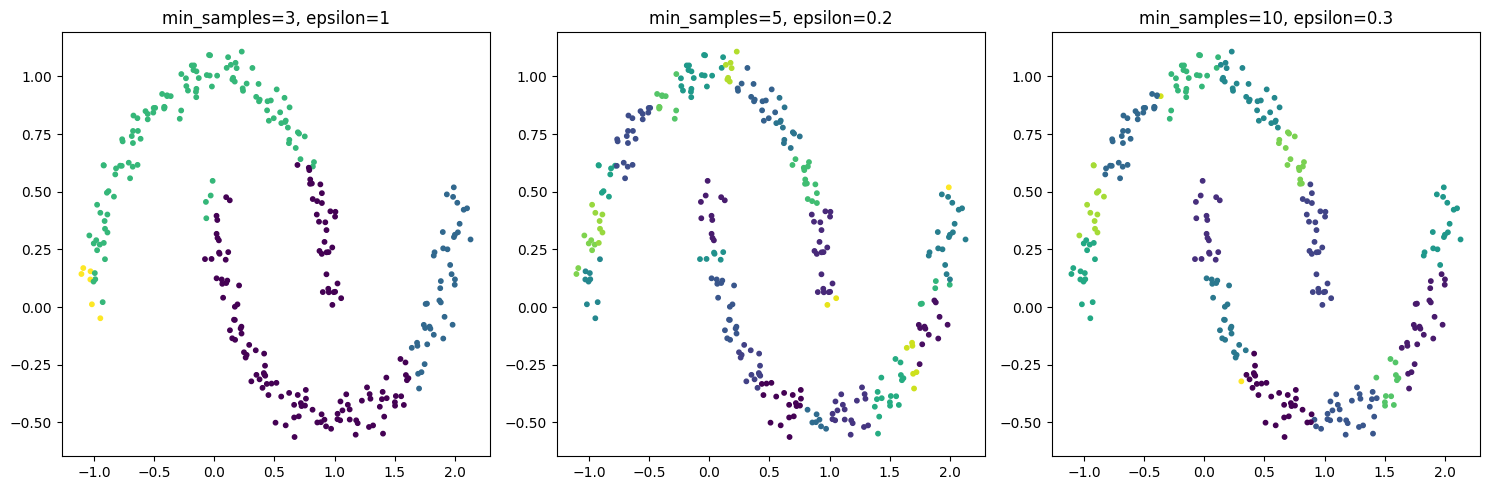

In [27]:
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

# Generate a test dataset
X_test, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Define test cases for DBSCAN
test_cases = [
    {"min_samples": 3, "epsilon": 1},
    {"min_samples": 5, "epsilon": 0.2},
    {"min_samples": 10, "epsilon": 0.3},
]

# Plot results for each test case
fig, axes = plt.subplots(1, len(test_cases), figsize=(15, 5))
for i, params in enumerate(test_cases):
    cluster_labels, point_labels = dbscan(X_test, params["min_samples"], params["epsilon"])
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=cluster_labels, cmap="viridis", s=10)
    axes[i].set_title(f"min_samples={params['min_samples']}, epsilon={params['epsilon']}")
plt.tight_layout()
plt.show()

##  EM para GMMs

### Inicialización:
Decidir cuantos clusters (c) utilizaremos. Luego, inicializar los parámetros para $c$ normales: $c$ medias ($\mu_c$), $c$  desvios ($\sigma_c$), y $c$ pesos ($\pi_c$).

### Paso E:

Calcular para cada punto $x^{(i)}$ la probabilidad ($r_{ic}$) de que el punto pertenezca al cluster c:
$$r_{ic} = P(c | x^{(i)}) = \frac{P(c)P(x^{(i)} | c)}{P(x^{(i)})} = \frac{\pi_c N(x^{(i)} \ | \ \mu_c,\sigma_c)}{\Sigma_{k=1}^K \pi_k N(x^{(i)} \ | \ \mu_k,\sigma_k)}$$

donde 

$${\displaystyle {\begin{aligned}N(x^{(i)},\mu_c,\sigma_c)&{}={\frac {1}{\sigma_c {\sqrt {2\pi }}}}e^{-{\frac {(x^{(i)}-\mu_c )^{2}}{2\sigma_c ^{2}}}},\quad \pi = 3.141592... .\\\end{aligned}}}$$

### Paso M:
Para cada cluster c, actualizar $\pi_c$, $\mu_c$, y $\sigma_c$ según los datos:

$$ N_c = \sum_{i}{r_{ic}}$$

$$ \mu^{(nuevo)}_c = \frac{1}{N_c}\sum_{i}{r_{ic}x^{(i)}}$$
$$ \sigma^{(nuevo)}_c = \frac{1}{N_c}\sum_{i}{r_{ic}(x^{(i)} - \mu^{(nuevo)}_c)^2} $$
$$ \pi^{(nuevo)}_c = \frac{N_c}{n}$$



### Iterar 
Iterar hasta que la log-likelihood del modelo converja:

$$ln \ p(\boldsymbol{X} \ | \ \boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\sigma}) \ = \ \Sigma_{i=1}^N \ ln(\Sigma_{k=1}^K \pi_k N(x^{(i)} \ | \ \mu_k,\sigma_k))$$

In [ ]:
%matplotlib inline
import scipy.stats
from sklearn.cluster import KMeans
import math 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def gmm_train(X, n_clusters, tolerance = 1e-3):
    v_mu, v_sigma, v_pi = inicializacion(n_clusters, X)
    old_llk = 0
    tolerance = 1e-3 # indica la mínima ganancia en llk para que el algoritmo continúe.
    gain = np.inf

    while(gain > tolerance):
        print_iter(v_mu, v_sigma, v_pi, n_clusters)
        r = e(X, n_clusters, v_mu, v_sigma, v_pi)
        v_mu, v_sigma, v_pi = m(X, n_clusters, r)
        llk = log_likelihood(X, v_mu, v_sigma, v_pi, n_clusters)
        print("Log likelihood: ", llk)
        gain = llk - old_llk
   
    return v_mu, v_sigma, v_pi

def inicializacion(n_clusters, X):
    ##################
    # COMPLETAR
    # Inicializar v_mu, v_sigma, v_pi (vectores que contienen una componente por cluster)
    ##################
    
    return v_mu, v_sigma, v_pi

def norm(x, mu, sigma):
    return scipy.stats.norm(mu, sigma).pdf(x)

def e(X, n_clusters, v_mu, v_sigma, v_pi):
    r = np.ones((len(X), n_clusters))
    
    ##################
    # COMPLETAR
    # r[i, c] debera contener la probabilidad estimada P(c | x^(i))
    ##################
    
    return r

def m(X, n_clusters, r):
    N = np.zeros(n_clusters)
    v_mu_new = np.zeros(n_clusters)
    v_sigma_new = np.zeros(n_clusters)
    v_pi_new = np.zeros(n_clusters)
    
    ##################
    # COMPLETAR
    # v_mu_new, v_sigma_new, v_pi_new deberán contener los valores actualizados.
    ##################
    
    return v_mu_new, v_sigma_new, v_pi_new


def log_likelihood(X, v_mu, v_sigma, v_pi, n_clusters):
    suma = 0
    for i in range(len(X)):
        suma_k = 0
        for k in range(n_clusters):
            suma_k += v_pi[k] * norm(X[i], v_mu[k], v_sigma[k])
        suma += math.log(suma_k)
    return suma


def print_iter( v_mu, v_sigma, v_pi, n_clusters):
    for c in range(n_clusters):
        print("C{} => mu={} +- {} (pi={})".format(c+1, "%.2f" % v_mu[c], "%.2f" % v_sigma[c], "%.2f" % v_pi[c]), end=" | ")
    print()

def dibujar(X, v_mu, v_sigma, v_pi, n_clusters, title="GMMs"):
    plt.figure()
    plt.title(title)
    colors = sns.color_palette("hls", n_clusters)
    plt.plot(X, [1] * len(X), ".")
    for k in range(n_clusters):
        col = colors[k]
#         plt.plot([v_mu[k], v_mu[k]], [0, 2], label="$\mu_{}$".format(k), color=col)
        plt.plot([v_mu[k] - v_sigma[k], v_mu[k] + v_sigma[k]], [1.1,1.1], color=col, label="$\mu_{}$".format(k))
        plt.plot([v_mu[k] - v_sigma[k], v_mu[k] - v_sigma[k]], [0.9,1.2], color=col)
        plt.plot([v_mu[k] + v_sigma[k], v_mu[k] + v_sigma[k]], [0.9,1.2], color=col)
    plt.yticks([])
    plt.ylim([0, 2])
    plt.legend()


In [ ]:
# Datos para ejemplo
np.random.seed(134)
X = np.array([10, 11, 12, 20, 21, 22, 30, 31, 32, 29, 33])
n_clusters = 3

# DESCOMENTAR
v_mu, v_sigma, v_pi = gmm_train(X, n_clusters)
dibujar(X, v_mu, v_sigma, v_pi, n_clusters, title="implementacion propia")
#print("DESCOMENTAR lo anterior")

print("Salida esperada:")
# SALIDA ESPERADA:
sklearn_gmm = GaussianMixture(n_components=3)
sklearn_gmm.fit(X.reshape(-1, 1))

dibujar(X, sklearn_gmm.means_.ravel(), sklearn_gmm.covariances_.ravel(), sklearn_gmm.weights_.ravel(), n_clusters, title="sklearn")


-------------------------------------------------------------------